# Generational changes in religious attitudes

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)

from scipy.special import expit

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

In [2]:
# !wget https://gssdataexplorer.norc.org/extracts/21438/download

In [3]:
gss = utils.ReadGss('gss_religion_data')
print(gss.shape)
gss.head()

(62466, 11)


,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god
0,1972,0,0,1949,23,0.4446,0,3,16,1,0
1,1972,0,0,1902,70,0.8893,0,2,10,2,0
2,1972,0,0,1924,48,0.8893,0,1,12,3,0
3,1972,0,0,1945,27,0.8893,0,5,17,4,0
4,1972,0,0,1911,61,0.8893,0,1,12,5,0


Cleaning variables

In [4]:
# TODO: find out what code 4 is

gss.bible.replace([4, 8, 9, 0], np.nan, inplace=True)

In [5]:
utils.values(gss, 'bible')

1.0    11185
2.0    15926
3.0     5929
Name: bible, dtype: int64

In [6]:
gss.conclerg.replace([8, 9, 0], np.nan, inplace=True)

In [7]:
utils.values(gss, 'conclerg')

1.0    11366
2.0    20886
3.0     8660
Name: conclerg, dtype: int64

In [8]:
gss.god.replace([8, 9, 0], np.nan, inplace=True)
sum(gss.god.isnull())

40129

In [9]:
utils.values(gss, 'god')

1.0      673
2.0     1110
3.0     2286
4.0      900
5.0     3662
6.0    13706
Name: god, dtype: int64

In [10]:
gss.age.replace([98, 99], np.nan, inplace=True)
sum(gss.age.isnull())

221

In [11]:
gss.cohort.replace([9999], np.nan, inplace=True)
sum(gss.cohort.isnull())

221

In [12]:
gss.relig.replace([98, 99], np.nan, inplace=True)
sum(gss.relig.isnull())

269

In [13]:
gss.dropna(subset=['age', 'cohort', 'relig'], inplace=True)
gss.shape

(61995, 11)

We drop 471 records due to missing data.

In [14]:
62466 - 61995

471

Here's the distribution of ages.

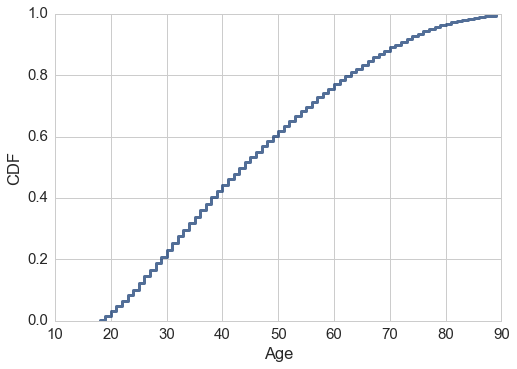

In [15]:
thinkplot.Cdf(thinkstats2.Cdf(gss.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

Group people into 5-year age groups.

In [16]:
gss['age_group'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5

Here's the distribution of birth year.

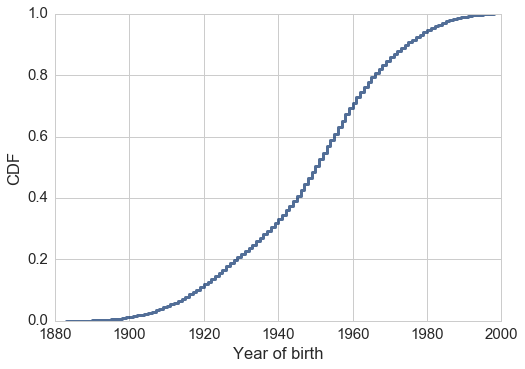

In [17]:
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort))
thinkplot.Config(xlabel='Year of birth', ylabel='CDF')

Group people into 5- and 10-year bins by birth year.

In [18]:
gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5) + 2.5

In [19]:
gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)

Here's the distribution of religion codes.

In [20]:
utils.values(gss, 'relig')

1.0     35856
2.0     15136
3.0      1233
4.0      7231
5.0      1064
6.0       177
7.0        88
8.0        38
9.0       135
10.0      112
11.0      760
12.0       30
13.0      135
Name: relig, dtype: int64

Resampling (bootstrapping to be more specific) to account for sampling weights.

In [21]:
sample = utils.ResampleByYear(gss)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god,age_group,cohort5,cohort10
0,1972,NaN,NaN,1933.0,39.0,0.8893,0,1.0,12,1573,NaN,37.5,1932.5,1930.0
1,1972,NaN,NaN,1916.0,56.0,1.3339,0,2.0,11,1351,NaN,57.5,1917.5,1910.0
2,1972,NaN,NaN,1944.0,28.0,0.8893,0,1.0,14,855,NaN,27.5,1942.5,1940.0
3,1972,NaN,NaN,1900.0,72.0,0.8893,0,1.0,16,625,NaN,72.5,1902.5,1900.0
4,1972,NaN,NaN,1928.0,44.0,1.3339,0,1.0,14,1580,NaN,42.5,1927.5,1920.0


## How does religious affiliation change with age?

In [22]:
varnames = ['prot', 'cath', 'none', 'other']

def create_relig_vars(df):
    """Creates columns for religious categories.
    
    df: DataFrame
    """
    # the second line lumps "Orthodox-Christian" and "Christian" with Protestant
    #df['prot'] = (df.relig==1)
    df['prot'] = (df.relig.isin([1,10,11]))

    df['cath'] = (df.relig==2)
    df['none'] = (df.relig==4)
    df['other'] = (df.relig.isin([3,5,6,7,8,9,12,13]))
    
    df['relig4'] = df.relig.copy()
    df.relig4.replace([10, 11], 1, inplace=True)
    df.relig4.replace([5,6,7,8,9,12,13], 3, inplace=True)

    df.loc[df.relig.isnull(), varnames + ['relig4']] = np.nan
    
create_relig_vars(sample)

Group by decade of birth and age group.

In [23]:
grouped = sample.groupby(['cohort10', 'age_group'])

Count the number of observations in each decade/age group.

In [24]:
counts = grouped.none.count().unstack()
counts

age_group,17.5,22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5,87.5
cohort10,,,,,,,,,,,,,,,
1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,40.0
1890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,178.0,152.0,80.0
1900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,384.0,517.0,328.0,234.0,133.0
1910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,622.0,729.0,685.0,660.0,472.0,247.0,200.0
1920.0,NaN,NaN,NaN,NaN,NaN,83.0,743.0,1016.0,920.0,933.0,761.0,581.0,456.0,281.0,175.0
1930.0,NaN,NaN,NaN,96.0,652.0,1046.0,946.0,928.0,746.0,686.0,635.0,521.0,411.0,163.0,22.0
1940.0,NaN,118.0,838.0,1125.0,1190.0,1332.0,1367.0,1203.0,1013.0,903.0,638.0,294.0,37.0,NaN,NaN
1950.0,325.0,1498.0,1489.0,1636.0,1703.0,1603.0,1557.0,1289.0,1059.0,595.0,86.0,NaN,NaN,NaN,NaN
1960.0,322.0,1650.0,1532.0,1628.0,1522.0,1474.0,1078.0,699.0,96.0,NaN,NaN,NaN,NaN,NaN,NaN


Compute the percentage of Nones in each group.

In [25]:
percent_none = grouped.none.mean().unstack()
percent_none

age_group,17.5,22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5,87.5
cohort10,,,,,,,,,,,,,,,
1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,0.000000
1890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018182,0.050562,0.019737,0.012500
1900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052632,0.023438,0.042553,0.012195,0.042735,0.022556
1910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.075000,0.035370,0.034294,0.040876,0.048485,0.027542,0.020243,0.065000
1920.0,NaN,NaN,NaN,NaN,NaN,0.024096,0.034993,0.018701,0.040217,0.030011,0.039422,0.043029,0.063596,0.049822,0.074286
1930.0,NaN,NaN,NaN,0.052083,0.064417,0.051625,0.061311,0.035560,0.034853,0.043732,0.072441,0.049904,0.046229,0.104294,0.136364
1940.0,NaN,0.127119,0.124105,0.100444,0.091597,0.069820,0.081931,0.091438,0.100691,0.104097,0.119122,0.088435,0.135135,NaN,NaN
1950.0,0.138462,0.094793,0.127602,0.081907,0.102760,0.127885,0.134232,0.114042,0.147309,0.171429,0.174419,NaN,NaN,NaN,NaN
1960.0,0.177019,0.109697,0.124021,0.127764,0.157687,0.144505,0.191095,0.191702,0.197917,NaN,NaN,NaN,NaN,NaN,NaN


Drop cells where we have fewer than 50 observations.

In [26]:
percent_none[counts < 50] = np.nan

Select rows for people born in the 1930s through 1980s.

In [27]:
decades = np.linspace(1930, 1980, 6, endpoint=True)
percent_none.loc[decades]

age_group,17.5,22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5,87.5
cohort10,,,,,,,,,,,,,,,
1930.0,NaN,NaN,NaN,0.052083,0.064417,0.051625,0.061311,0.035560,0.034853,0.043732,0.072441,0.049904,0.046229,0.104294,NaN
1940.0,NaN,0.127119,0.124105,0.100444,0.091597,0.069820,0.081931,0.091438,0.100691,0.104097,0.119122,0.088435,NaN,NaN,NaN
1950.0,0.138462,0.094793,0.127602,0.081907,0.102760,0.127885,0.134232,0.114042,0.147309,0.171429,0.174419,NaN,NaN,NaN,NaN
1960.0,0.177019,0.109697,0.124021,0.127764,0.157687,0.144505,0.191095,0.191702,0.197917,NaN,NaN,NaN,NaN,NaN,NaN
1970.0,0.155556,0.192251,0.201365,0.222481,0.190698,0.226891,0.164179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980.0,0.175758,0.269880,0.287511,0.289086,0.219512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Choose some colors.

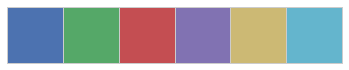

In [28]:
colors = sns.color_palette()
sns.palplot(colors)

For each birth cohort, plot the percentage of Nones as a function of age.

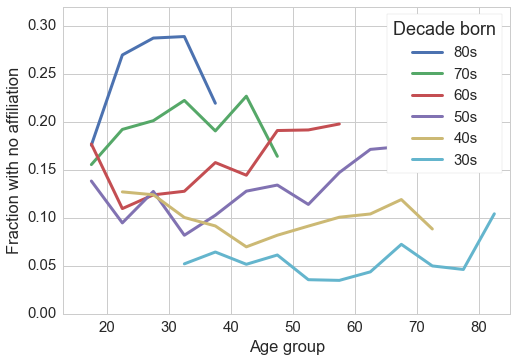

In [29]:
options = dict(alpha=1)

thinkplot.preplot(6)
thinkplot.plot(percent_none.loc[1980], label='80s', color=colors[0], **options)
thinkplot.plot(percent_none.loc[1970], label='70s', color=colors[1], **options)
thinkplot.plot(percent_none.loc[1960], label='60s', color=colors[2], **options)
thinkplot.plot(percent_none.loc[1950], label='50s', color=colors[3], **options)
thinkplot.plot(percent_none.loc[1940], label='40s', color=colors[4], **options)
thinkplot.plot(percent_none.loc[1930], label='30s', color=colors[5], **options)

xlabel = 'Age group'
ylabel = 'Fraction with no affiliation'
axis = [13, 85, 0, 0.32]

thinkplot.config(xlabel=xlabel, ylabel=ylabel, axis=axis, legend=True)
plt.gca().get_legend().set(title='Decade born');

Same as the previous, but as a multi-plot.

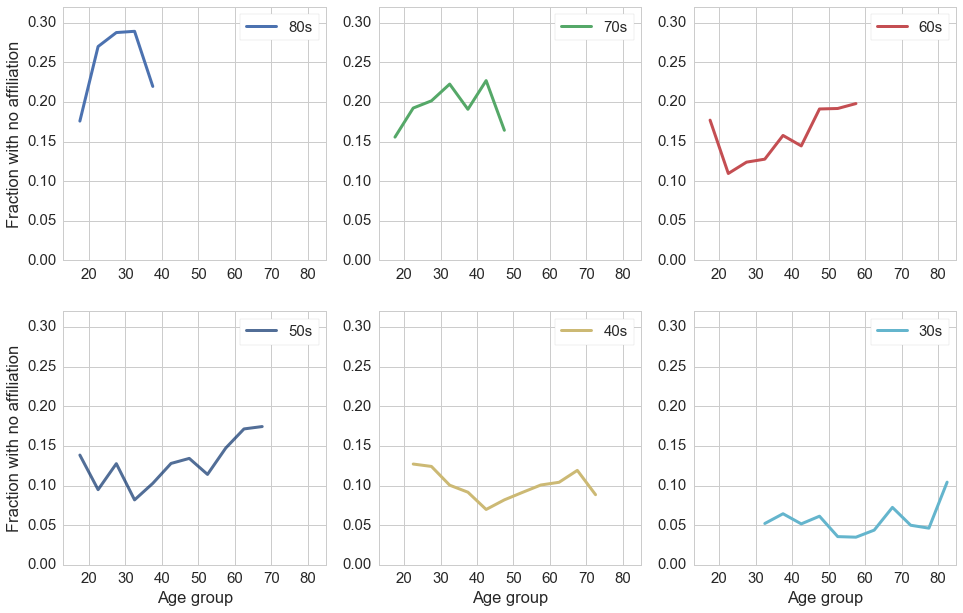

In [30]:
thinkplot.preplot(num=6, rows=2, cols=3)
thinkplot.subplot(1)
thinkplot.plot(percent_none.loc[1980], label='80s', color=colors[0], **options)
thinkplot.config(ylabel=ylabel, axis=axis)

thinkplot.subplot(2)
thinkplot.plot(percent_none.loc[1970], label='70s', color=colors[1], **options)
thinkplot.config(axis=axis)

thinkplot.subplot(3)
thinkplot.plot(percent_none.loc[1960], label='60s', color=colors[2], **options)
thinkplot.config(axis=axis)

thinkplot.subplot(4)
thinkplot.plot(percent_none.loc[1950], label='50s')
thinkplot.config(xlabel=xlabel, ylabel=ylabel, axis=axis, color=colors[3], **options)

thinkplot.subplot(5)
thinkplot.plot(percent_none.loc[1940], label='40s', color=colors[4], **options)
thinkplot.config(xlabel=xlabel, axis=axis)

thinkplot.subplot(6)
thinkplot.plot(percent_none.loc[1930], label='30s', color=colors[5], **options)
thinkplot.config(xlabel=xlabel, axis=axis)

In [31]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors for the model.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['c2'] = df.c**2
    df['a'] = df.age - 47
    df['a2'] = df.a**2
    df['ac'] = df.a * df.c

In [32]:
center_factors(sample)

In [33]:
formula = 'prot ~ c + c2 + a + a2'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.665006
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   prot   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Mon, 29 May 2017   Pseudo R-squ.:                 0.02064
Time:                        20:28:29   Log-Likelihood:                -41227.
converged:                       True   LL-Null:                       -42096.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0867      0.017      5.241      0.000       0.054       0.119
c             -0.0195      0.001    -22.132      0.000      -0.021      -0.018
c2         -9.019e-05   1.84e-05     -4.894      0.000      -0.000   -5.41e-05
a              0.0005      0.001      0.701      0.483      -0.001       0.002
a2          6.699e-06   3.14e-05      0.214      0.831   -5.48e-05    6.82e-05
==============================================================================
"""

In [34]:
formula = 'cath ~ c + c2 + a + a2'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.566714
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   cath   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.001854
Time:                        20:28:30   Log-Likelihood:                -35133.
converged:                       True   LL-Null:                       -35199.
                                        LLR p-value:                 3.060e-27
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1257      0.019    -59.847      0.000      -1.163      -1.089
c             -0.0051      0.001     -5.201      0.000      -0.007      -0.003
c2         -8.773e-05   2.05e-05     -4.280      0.000      -0.000   -4.76e-05
a             -0.0070      0.001     -8.027      0.000      -0.009      -0.005
a2          3.761e-05   3.49e-05      1.078      0.281   -3.07e-05       0.000
==============================================================================
"""

In [35]:
formula = 'none ~ c + c2 + a + a2'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.336051
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   none   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Mon, 29 May 2017   Pseudo R-squ.:                 0.06065
Time:                        20:28:31   Log-Likelihood:                -20833.
converged:                       True   LL-Null:                       -22179.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5232      0.024    -63.759      0.000      -1.570      -1.476
c              0.0401      0.001     33.077      0.000       0.038       0.042
c2         -1.633e-05   3.31e-05     -0.493      0.622   -8.12e-05    4.85e-05
a              0.0110      0.001      8.282      0.000       0.008       0.014
a2          3.155e-05   5.53e-05      0.570      0.568   -7.69e-05       0.000
==============================================================================
"""

In [36]:
formula = 'other ~ c + c2 + a + a2'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.184971
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  other   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.003899
Time:                        20:28:31   Log-Likelihood:                -11467.
converged:                       True   LL-Null:                       -11512.
                                        LLR p-value:                 1.477e-18
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8484      0.037    -76.418      0.000      -2.922      -2.775
c              0.0127      0.002      6.480      0.000       0.009       0.017
c2          2.045e-05   4.25e-05      0.482      0.630   -6.28e-05       0.000
a              0.0057      0.002      3.097      0.002       0.002       0.009
a2          1.456e-05   7.37e-05      0.198      0.843      -0.000       0.000
==============================================================================
"""

## Generational replacement

Choose colors

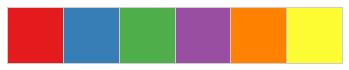

In [37]:
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')
sns.palplot(sns.color_palette('Set1'))

In [38]:
def make_series_seq(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: list of Series
    """
    return [grouped[var].mean() * 100 for var in varnames]

def plot_series_seq(series_seq, colors, labels):
    """Plots Series objects.
    
    series_seq: list of Series
    colors: list of string colors
    labels: list of string labels
    """
    for series, color, label in zip(series_seq, colors, labels):
        thinkplot.plot(series, color=color, label=label)

In [39]:
def plot_relig(grouped, varnames):
    """Plot one line for each religious group.
    
    grouped: GroupBy object with one-hots for each religious group
    """
    colors = [ORANGE, GREEN, RED, BLUE]
    labels = ['Protestant', 'Catholic', 'None', 'Other']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

Plot the percentage in each religious group as a function of interview year.

In [40]:
grouped_year = sample.groupby(['year'])
grouped_year.none.count()

year
1972    1603
1973    1496
1974    1477
1975    1483
1976    1491
1977    1516
1978    1522
1980    1456
1982    1837
1983    1588
1984    1456
1985    1522
1986    1460
1987    1802
1988    1476
1989    1530
1990    1367
1991    1513
1993    1592
1994    2976
1996    2894
1998    2792
2000    2805
2002    2735
2004    2792
2006    4468
2008    2004
2010    2028
2012    1962
2014    2513
2016    2839
Name: none, dtype: int64

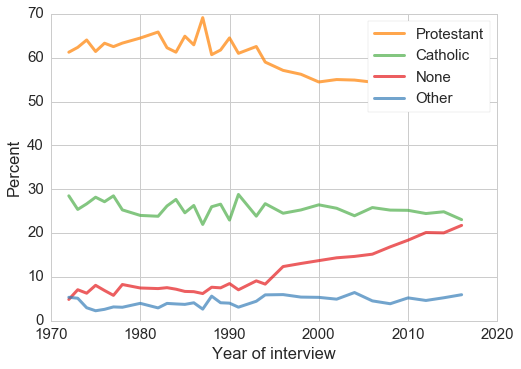

In [41]:
plot_relig(grouped_year, varnames)
thinkplot.config(xlabel='Year of interview', ylabel='Percent')

In [42]:
grouped_age = sample.groupby(['age_group'])
grouped_age.none.count()

age_group
17.5    1466
22.5    6428
27.5    6530
32.5    6453
37.5    6224
42.5    6133
47.5    5758
52.5    5215
57.5    4456
62.5    3903
67.5    3189
72.5    2628
77.5    1882
82.5    1080
87.5     650
Name: none, dtype: int64

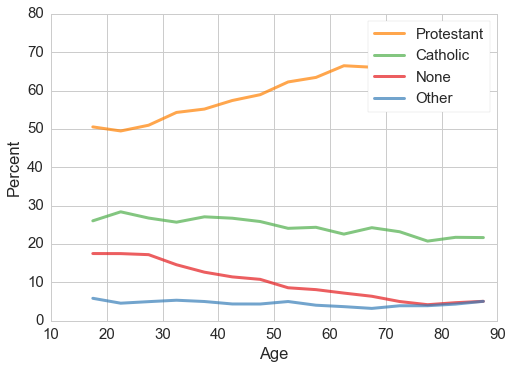

In [43]:
plot_relig(grouped_age, varnames)
thinkplot.config(xlabel='Age', ylabel='Percent')

Plot the percentage in each religious group as a function of birth cohort.

In [44]:
grouped_cohort = sample.groupby(['cohort5'])
grouped_cohort.relig.count()

cohort5
1882.5       5
1887.5      38
1892.5     131
1897.5     334
1902.5     596
1907.5    1057
1912.5    1542
1917.5    2153
1922.5    2797
1927.5    3152
1932.5    3126
1937.5    3726
1942.5    4486
1947.5    5572
1952.5    6458
1957.5    6382
1962.5    5546
1967.5    4455
1972.5    3423
1977.5    2707
1982.5    2080
1987.5    1368
1992.5     666
1997.5     195
Name: relig, dtype: int64

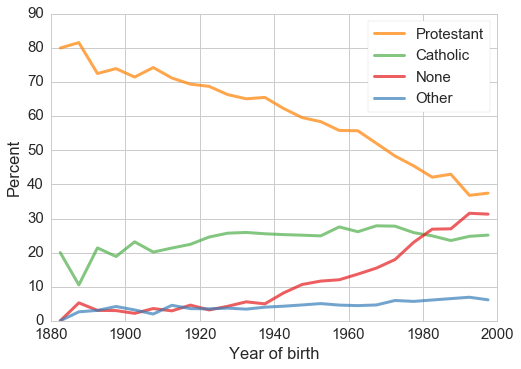

In [45]:
plot_relig(grouped_cohort, varnames)
thinkplot.config(xlabel='Year of birth', ylabel='Percent')

Before running models, center the factors we're planning to use.

In [46]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors for the model.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['c2'] = df.c**2
    df['a'] = df.age - 47
    df['a2'] = df.a**2
    df['ac'] = df.a * df.c

In [47]:
center_factors(sample)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,...,cath,none,other,relig4,ones,c,c2,a,a2,ac
0,1972,NaN,NaN,1933.0,39.0,0.8893,0,1.0,12,1573,...,0.0,0.0,0.0,1.0,1.0,-33.0,1089.0,-8.0,64.0,264.0
1,1972,NaN,NaN,1916.0,56.0,1.3339,0,2.0,11,1351,...,1.0,0.0,0.0,2.0,1.0,-50.0,2500.0,9.0,81.0,-450.0
2,1972,NaN,NaN,1944.0,28.0,0.8893,0,1.0,14,855,...,0.0,0.0,0.0,1.0,1.0,-22.0,484.0,-19.0,361.0,418.0
3,1972,NaN,NaN,1900.0,72.0,0.8893,0,1.0,16,625,...,0.0,0.0,0.0,1.0,1.0,-66.0,4356.0,25.0,625.0,-1650.0
4,1972,NaN,NaN,1928.0,44.0,1.3339,0,1.0,14,1580,...,0.0,0.0,0.0,1.0,1.0,-38.0,1444.0,-3.0,9.0,114.0


Run logistic regression to fit models to each religious group.

In [48]:
def make_model(df, var):
    """Fit a logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    """
    formula = var + ' ~ c + c2 + a + a2 + ac'
    return smf.logit(formula, data=df).fit()

In [49]:
make_model(sample, 'prot').summary()

Optimization terminated successfully.
         Current function value: 0.664652
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   prot   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                 0.02116
Time:                        20:28:38   Log-Likelihood:                -41205.
converged:                       True   LL-Null:                       -42096.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0194      0.019      1.002      0.316      -0.019       0.057
c             -0.0322      0.002    -15.270      0.000      -0.036      -0.028
c2            -0.0004   5.31e-05     -7.915      0.000      -0.001      -0.000
a             -0.0133      0.002     -5.964      0.000      -0.018      -0.009
a2            -0.0004   6.67e-05     -5.761      0.000      -0.001      -0.000
ac            -0.0007      0.000     -6.632      0.000      -0.001      -0.001
==============================================================================
"""

In [50]:
make_model(sample, 'cath').summary()

Optimization terminated successfully.
         Current function value: 0.566684
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   cath   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.001907
Time:                        20:28:39   Log-Likelihood:                -35132.
converged:                       True   LL-Null:                       -35199.
                                        LLR p-value:                 3.027e-27
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1029      0.022    -49.804      0.000      -1.146      -1.060
c             -0.0010      0.002     -0.405      0.685      -0.006       0.004
c2          1.963e-05   5.92e-05      0.332      0.740   -9.64e-05       0.000
a             -0.0025      0.003     -0.979      0.328      -0.007       0.002
a2             0.0002   7.44e-05      2.215      0.027     1.9e-05       0.000
ac             0.0002      0.000      1.933      0.053   -3.26e-06       0.000
==============================================================================
"""

In [51]:
make_model(sample, 'none').summary()

Optimization terminated successfully.
         Current function value: 0.335701
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   none   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                 0.06163
Time:                        20:28:39   Log-Likelihood:                -20812.
converged:                       True   LL-Null:                       -22179.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4407      0.027    -54.075      0.000      -1.493      -1.388
c              0.0587      0.003     19.160      0.000       0.053       0.065
c2             0.0005   8.43e-05      5.923      0.000       0.000       0.001
a              0.0311      0.003      9.437      0.000       0.025       0.038
a2             0.0007      0.000      6.051      0.000       0.000       0.001
ac             0.0012      0.000      6.648      0.000       0.001       0.001
==============================================================================
"""

In [52]:
make_model(sample, 'other').summary()

Optimization terminated successfully.
         Current function value: 0.184947
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  other   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.004028
Time:                        20:28:40   Log-Likelihood:                -11466.
converged:                       True   LL-Null:                       -11512.
                                        LLR p-value:                 1.778e-18
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8860      0.044    -66.289      0.000      -2.971      -2.801
c              0.0051      0.005      1.067      0.286      -0.004       0.015
c2            -0.0002      0.000     -1.453      0.146      -0.000    6.33e-05
a             -0.0026      0.005     -0.497      0.619      -0.013       0.008
a2            -0.0002      0.000     -1.430      0.153      -0.001     8.5e-05
ac            -0.0004      0.000     -1.719      0.086      -0.001     6.3e-05
==============================================================================
"""

In [53]:
formula = 'relig4 ~ a + c'
model = smf.mnlogit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 1.026513
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 relig4   No. Observations:                61995
Model:                        MNLogit   Df Residuals:                    61986
Method:                           MLE   Df Model:                            6
Date:                Mon, 29 May 2017   Pseudo R-squ.:                 0.02508
Time:                        20:28:41   Log-Likelihood:                -63639.
converged:                       True   LL-Null:                       -65276.
                                        LLR p-value:                     0.000
==============================================================================
  relig4=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7432      0.017    -42.798      0.000      -0.777      -0.709
a             -0.0053      0.001     -5.931      0.000      -0.007      -0.004
c              0.0055      0.001      7.307      0.000       0.004       0.007
------------------------------------------------------------------------------
  relig4=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2266      0.033    -67.450      0.000      -2.291      -2.162
a              0.0058      0.002      3.162      0.002       0.002       0.009
c              0.0189      0.002     12.261      0.000       0.016       0.022
------------------------------------------------------------------------------
  relig4=4       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0564      0.021    -49.469      0.000      -1.098      -1.015
a              0.0096      0.001      7.321      0.000       0.007       0.012
c              0.0431      0.001     39.550      0.000       0.041       0.045
==============================================================================
"""

In [54]:
from statsmodels.discrete.discrete_model import MNLogit

In [55]:
y = sample.relig4.values
X = sample[['ones', 'a', 'c']].values

model = MNLogit(y, X, missing='drop').fit()
model

Optimization terminated successfully.
         Current function value: 1.026513
         Iterations 6


In [56]:
model.params

array([[-0.74316195, -2.22655615, -1.0563789 ],
       [-0.00531749,  0.00584123,  0.00959441],
       [ 0.0054558 ,  0.01886378,  0.04308144]])

In [57]:
model.predict(X).mean(axis=0)

array([ 0.58383741,  0.25500444,  0.04571336,  0.11544479])

## Predict population

Predict future generations based on the models.

In [58]:
def predict_population(df, model_seq, year):
    """Make a prediction based on a fitted model.
    
    ???
    
    returns: Series that maps year of birth to predicted percentages
    """
    # TODO: consider resampling age and using
    # binomial rather than mean
    # age = thinkstats2.Resample(sample.age)
    age = df.loc[df.year>=2016, 'age']
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    
    pred = [results.predict(df).mean()
            for results in model_seq]
    return pd.Series(pred, index=varnames) * 100

In [59]:
model_seq = [make_model(sample, var) for var in varnames ]

Optimization terminated successfully.
         Current function value: 0.664652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.566684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.335701
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.184947
         Iterations 7


In [60]:
pred = predict_population(sample, model_seq, 2016)
print(sum(pred))
pred

100.570368226


prot     47.737728
cath     24.567237
none     22.833471
other     5.431933
dtype: float64

In [61]:
pred = predict_population(sample, model_seq, 2026)
print(sum(pred))
pred

104.412708512


prot     38.508026
cath     24.467561
none     35.882292
other     5.554829
dtype: float64

In [62]:
pred = predict_population(sample, model_seq, 2036)
print(sum(pred))
pred

112.156511692


prot     28.377529
cath     24.451720
none     53.837252
other     5.490010
dtype: float64

In [63]:
def predict_by_year(sample, model_seq, years):
    """Make predictions by year.
    
    sample: DataFrame
    model_seq: list of fitted models
    years: list of years to generate predictions for
    """
    df = pd.DataFrame(columns=varnames)
    for year in years:
        df.loc[year] = predict_population(sample, model_seq, year)
    return df

In [64]:
years = np.arange(1972, 2040)
df = predict_by_year(sample, model_seq, years)

In [65]:
def plot_predictions(series_seq, colors):
    """Plot a sequence of series.
    
    series_seq: list of series
    """
    alpha = 0.3
    for series, color in zip(series_seq, colors):
        thinkplot.plot(series, color=color, alpha=alpha)

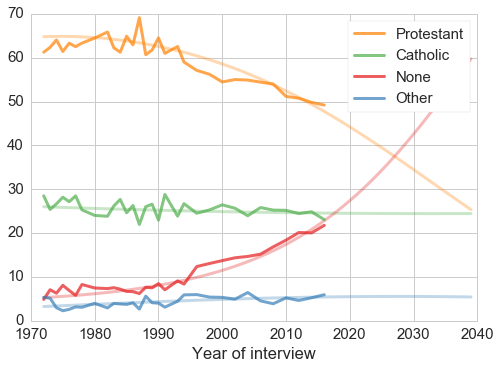

In [66]:
series_seq = [df[var] for var in varnames]
relig_colors = [ORANGE, GREEN, RED, BLUE]

plot_predictions(series_seq, relig_colors)
plot_relig(grouped_year, varnames)
thinkplot.config(xlabel='Year of interview', loc='upper right')

## Multinomial models

In [67]:
y = sample.relig4.values
X = sample[['ones', 'a', 'c']].values

model = MNLogit(y, X, missing='drop').fit()
model.predict(X).mean(axis=0)

Optimization terminated successfully.
         Current function value: 1.026513
         Iterations 6


array([ 0.58383741,  0.25500444,  0.04571336,  0.11544479])

In [68]:
def make_multi_model(df, var, factors):
    """Fit a multinomial logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    factors: list of string names for factors
    
    returns: MNLogit model
    """
    nonull = df.dropna(subset=factors+[var])
    y = nonull[var].values
    X = nonull[factors].values
    return MNLogit(y, X, missing='drop').fit()

In [69]:
def predict_multi_model(age, model, year, factors, index):
    """Make a prediction based on a fitted model.
    
    age: Series of ages to simulate
    model: MNLogit model
    year: year to make a prediction for
    factors: list of string names for factors
    index: list of strings, index of result Series
    
    returns: Series that maps variable name to percentage
    """
    # TODO: consider resampling age and using
    # binomial rather than mean
    # age = thinkstats2.Resample(sample.age)
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    X = df[factors].values
    pred = model.predict(X).mean(axis=0)
    return pd.Series(pred, index=index) * 100

In [70]:
train_year = 2016
train = sample[sample.year <= train_year]

In [71]:
factors = ['ones', 'a', 'c']
model = make_multi_model(train, 'relig4', factors)

Optimization terminated successfully.
         Current function value: 1.026513
         Iterations 6


In [72]:
age = sample.loc[sample.year==train_year, 'age']
index = ['prot', 'cath', 'other', 'none']

predict_multi_model(age, model, 2016, factors, index)

prot     50.012495
cath     23.686971
other     5.594613
none     20.705920
dtype: float64

In [73]:
predict_multi_model(age, model, 2026, factors, index)

prot     44.354110
cath     22.032923
other     5.942130
none     27.670838
dtype: float64

In [74]:
predict_multi_model(age, model, 2036, factors, index)

prot     38.201917
cath     19.881986
other     6.121267
none     35.794830
dtype: float64

In [75]:
def predict_by_year_multi(age, model, years, factors, index):
    """Make predictions by year.
    
    age: Series of ages
    model_seq: list of fitted models
    years: list of years to generate predictions for
    """
    pred = pd.DataFrame(columns=varnames)
    for year in years:
        pred.loc[year] = predict_multi_model(age, model, year, factors, index)
    return pred

In [76]:
years = np.arange(1972, 2040)
pred = predict_by_year_multi(age, model, years, factors, index)

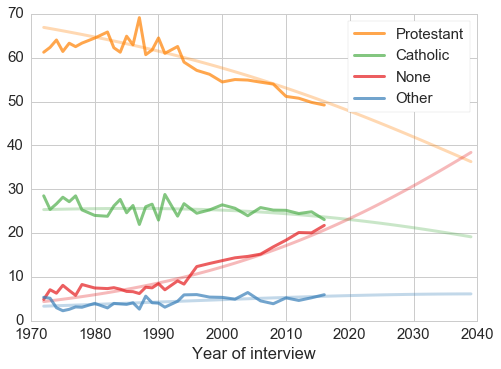

In [77]:
series_seq = [pred[var] for var in varnames]
plot_predictions(series_seq, relig_colors)

plot_relig(grouped_year, varnames)
thinkplot.config(xlabel='Year of interview', loc='upper right')

In [78]:
def make_multi_pred(df, var, varnames, train_year, years, factors, index):
    train = df[df.year <= train_year]
    age = df.loc[df.year==train_year, 'age']

    model = make_multi_model(train, var, factors)
    
    pred = pd.DataFrame(columns=varnames)
    for year in years:
        pred.loc[year] = predict_multi_model(age, model, year, factors, index)
    return pred

def plot_multi_pred(df, pred, varnames, colors):
    series_seq = [pred[var] for var in varnames]
    plot_predictions(series_seq, colors)
    thinkplot.config(xlabel='Year of interview', loc='upper right')

Optimization terminated successfully.
         Current function value: 0.977333
         Iterations 6


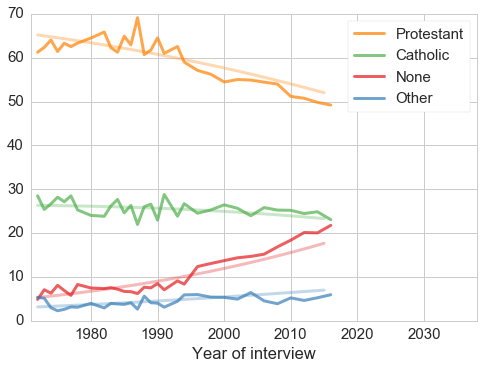

In [79]:
var = 'relig4'
varnames = ['prot', 'cath', 'none', 'other']
colors = [ORANGE, GREEN, RED, BLUE]
train_year = 2000
years = np.arange(1972, 2016)
factors = ['ones', 'a', 'c']
index = ['prot', 'cath', 'other', 'none']

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_relig(grouped_year, varnames)
thinkplot.config(xlim=[1971, 2038])

Optimization terminated successfully.
         Current function value: 1.026513
         Iterations 6


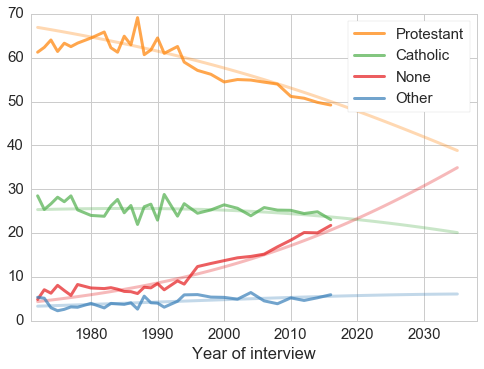

In [80]:
train_year = 2016
years = np.arange(1972, 2036)

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_relig(grouped_year, varnames)

thinkplot.config(xlim=[1971, 2038])

## Belief in God

In [81]:
varnames = ['strongbelief', 'belief', 'nobelief']

def create_belief_vars(df):
    """Creates columns for belief categories.
    
    df: DataFrame
    """
    df['nobelief'] = (df.god.isin([1, 2]))
    df['belief'] = (df.god.isin([3, 4, 5]))
    df['strongbelief'] = (df.god.isin([6]))
    
    df['belief3'] = df.god.copy()
    df.belief3.replace([1, 2], 1, inplace=True)
    df.belief3.replace([3, 4, 5], 2, inplace=True)
    df.belief3.replace([6], 3, inplace=True)

    df.loc[df.god.isnull(), varnames + ['belief3']] = np.nan
    
create_belief_vars(sample)

In [82]:
utils.values(sample, 'belief3')

1.0     1800
2.0     6828
3.0    13610
Name: belief3, dtype: int64

In [83]:
RED, PINK, _, _, LTBLUE, DKBLUE = sns.color_palette('RdBu', 6)
belief_colors = [BLUE, PURPLE, RED]

In [84]:
def plot_beliefs(grouped, varnames):
    """Plot belief categories.
    
    grouped: GroupBy object
    """
    colors = [BLUE, PURPLE, RED]
    labels = ['Strong belief', 'Belief', 'No belief']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

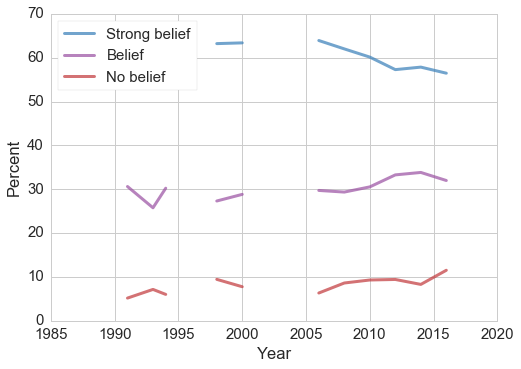

In [85]:
plot_beliefs(grouped_year, varnames)
thinkplot.config(xlabel='Year', ylabel='Percent', loc='upper left')

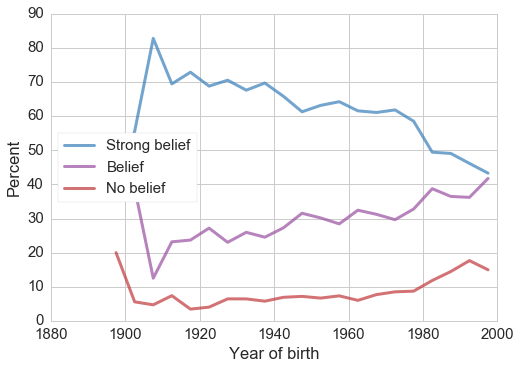

In [86]:
plot_beliefs(grouped_cohort, varnames)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='center left')

In [87]:
make_model(sample, 'strongbelief').summary()

Optimization terminated successfully.
         Current function value: 0.660093
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           strongbelief   No. Observations:                22238
Model:                          Logit   Df Residuals:                    22232
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                 0.01160
Time:                        20:29:13   Log-Likelihood:                -14679.
converged:                       True   LL-Null:                       -14851.
                                        LLR p-value:                 2.703e-72
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3961      0.023     17.187      0.000       0.351       0.441
c             -0.0359      0.005     -7.671      0.000      -0.045      -0.027
c2            -0.0011      0.000     -5.168      0.000      -0.002      -0.001
a             -0.0209      0.005     -4.383      0.000      -0.030      -0.012
a2            -0.0010      0.000     -4.504      0.000      -0.001      -0.001
ac            -0.0020      0.000     -4.594      0.000      -0.003      -0.001
==============================================================================
"""

In [88]:
make_model(sample, 'belief').summary()

Optimization terminated successfully.
         Current function value: 0.613503
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 belief   No. Observations:                22238
Model:                          Logit   Df Residuals:                    22232
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.005206
Time:                        20:29:13   Log-Likelihood:                -13643.
converged:                       True   LL-Null:                       -13714.
                                        LLR p-value:                 4.583e-29
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7550      0.024    -31.122      0.000      -0.803      -0.707
c              0.0273      0.005      5.551      0.000       0.018       0.037
c2             0.0010      0.000      4.510      0.000       0.001       0.001
a              0.0176      0.005      3.504      0.000       0.008       0.027
a2             0.0009      0.000      3.768      0.000       0.000       0.001
ac             0.0019      0.000      4.278      0.000       0.001       0.003
==============================================================================
"""

In [89]:
make_model(sample, 'nobelief').summary()

Optimization terminated successfully.
         Current function value: 0.276382
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               nobelief   No. Observations:                22238
Model:                          Logit   Df Residuals:                    22232
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                 0.01666
Time:                        20:29:14   Log-Likelihood:                -6146.2
converged:                       True   LL-Null:                       -6250.3
                                        LLR p-value:                 4.763e-43
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4346      0.041    -59.347      0.000      -2.515      -2.354
c              0.0319      0.008      3.882      0.000       0.016       0.048
c2             0.0004      0.000      1.024      0.306      -0.000       0.001
a              0.0149      0.008      1.771      0.077      -0.002       0.031
a2             0.0006      0.000      1.474      0.141      -0.000       0.001
ac             0.0005      0.001      0.691      0.490      -0.001       0.002
==============================================================================
"""

In [90]:
formula = 'belief3 ~ c + a'
model = smf.mnlogit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.858532
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                belief3   No. Observations:                22238
Model:                        MNLogit   Df Residuals:                    22232
Method:                           MLE   Df Model:                            4
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.009236
Time:                        20:29:14   Log-Likelihood:                -19092.
converged:                       True   LL-Null:                       -19270.
                                        LLR p-value:                 9.153e-76
==============================================================================
 belief3=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2267      0.034     35.910      0.000       1.160       1.294
c             -0.0188      0.003     -6.166      0.000      -0.025      -0.013
a             -0.0115      0.003     -3.425      0.001      -0.018      -0.005
------------------------------------------------------------------------------
 belief3=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8524      0.032     57.233      0.000       1.789       1.916
c             -0.0286      0.003     -9.851      0.000      -0.034      -0.023
a             -0.0101      0.003     -3.186      0.001      -0.016      -0.004
==============================================================================
"""

Optimization terminated successfully.
         Current function value: 0.858532
         Iterations 6


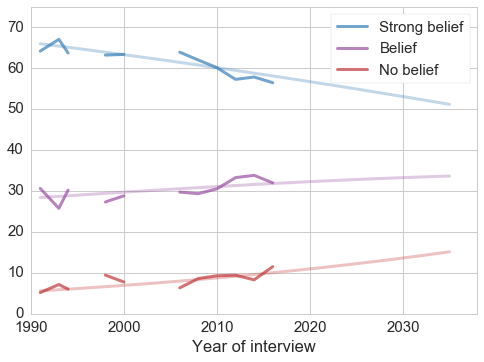

In [91]:
var = 'belief3'
varnames = ['strongbelief', 'belief', 'nobelief']
colors = [RED, PURPLE, BLUE]
train_year = 2016
years = np.arange(1991, 2036)
factors = ['ones', 'a', 'c']
index = varnames

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_beliefs(grouped_year, varnames)

thinkplot.config(xlim=[1990, 2038], ylim=[0, 75])

## Confidence in people running organized religion

As far as the people running this institution [organized religion] are concerned, would you say you have a great deal of confidence, only some confidence, or hardly any confidence at all in them?

1. A great deal
2. Only some
3. Hardly any



In [92]:
sum(sample.conclerg.isnull())

21349

In [93]:
varnames = ['confident', 'someconf', 'noconf']

def create_conf_vars(df):
    """Creates columns for confidence in religion categories.
    
    df: DataFrame
    """
    df['confident'] = (df.conclerg == 1)
    df['someconf'] = (df.conclerg == 2)
    df['noconf'] = (df.conclerg == 3)

    df.loc[df.conclerg.isnull(), varnames] = np.nan
    
create_conf_vars(sample)

In [94]:
def plot_conf(grouped, colors):
    """Plot confidence in religion categories.
    
    grouped: GroupBy object
    """
    labels = ['Great deal', 'Only some', 'Hardly any']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

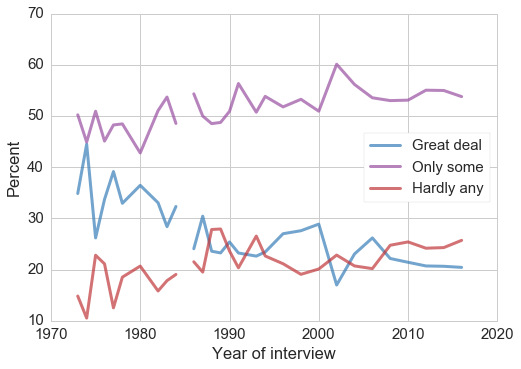

In [95]:
colors = [BLUE, PURPLE, RED]
plot_conf(grouped_year, colors)
thinkplot.config(xlabel='Year of interview', ylabel='Percent', loc='center right')

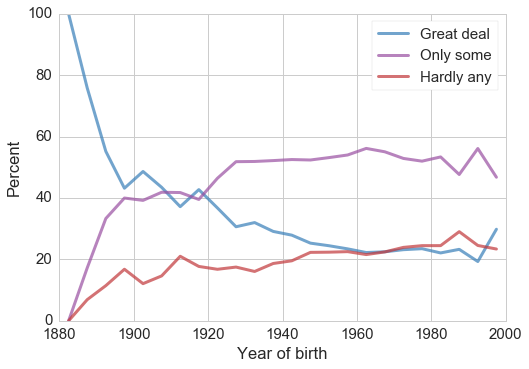

In [96]:
plot_conf(grouped_cohort, colors)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [97]:
make_model(sample, 'confident').summary()

Optimization terminated successfully.
         Current function value: 0.577937
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              confident   No. Observations:                40646
Model:                          Logit   Df Residuals:                    40640
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                 0.02061
Time:                        20:29:19   Log-Likelihood:                -23491.
converged:                       True   LL-Null:                       -23985.
                                        LLR p-value:                1.700e-211
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4520      0.029    -49.592      0.000      -1.509      -1.395
c             -0.0065      0.003     -2.153      0.031      -0.012      -0.001
c2             0.0003   7.36e-05      4.647      0.000       0.000       0.000
a             -0.0014      0.003     -0.450      0.653      -0.008       0.005
a2             0.0007   9.03e-05      7.459      0.000       0.000       0.001
ac             0.0005      0.000      3.290      0.001       0.000       0.001
==============================================================================
"""

In [98]:
make_model(sample, 'someconf').summary()

Optimization terminated successfully.
         Current function value: 0.688318
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               someconf   No. Observations:                40646
Model:                          Logit   Df Residuals:                    40640
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.006337
Time:                        20:29:19   Log-Likelihood:                -27977.
converged:                       True   LL-Null:                       -28156.
                                        LLR p-value:                 5.799e-75
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3036      0.024     12.458      0.000       0.256       0.351
c              0.0014      0.003      0.555      0.579      -0.004       0.006
c2            -0.0002   6.48e-05     -2.607      0.009      -0.000   -4.19e-05
a              0.0015      0.003      0.562      0.574      -0.004       0.007
a2            -0.0004    8.1e-05     -4.701      0.000      -0.001      -0.000
ac            -0.0001      0.000     -0.915      0.360      -0.000       0.000
==============================================================================
"""

In [99]:
make_model(sample, 'noconf').summary()

Optimization terminated successfully.
         Current function value: 0.508862
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 noconf   No. Observations:                40646
Model:                          Logit   Df Residuals:                    40640
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.005245
Time:                        20:29:20   Log-Likelihood:                -20683.
converged:                       True   LL-Null:                       -20792.
                                        LLR p-value:                 3.736e-45
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1469      0.029    -39.934      0.000      -1.203      -1.091
c              0.0016      0.003      0.513      0.608      -0.004       0.008
c2            -0.0003   7.98e-05     -3.479      0.001      -0.000      -0.000
a             -0.0031      0.003     -0.918      0.358      -0.010       0.003
a2            -0.0003      0.000     -2.872      0.004      -0.000   -9.13e-05
ac            -0.0005      0.000     -3.161      0.002      -0.001      -0.000
==============================================================================
"""

Optimization terminated successfully.
         Current function value: 1.014331
         Iterations 5


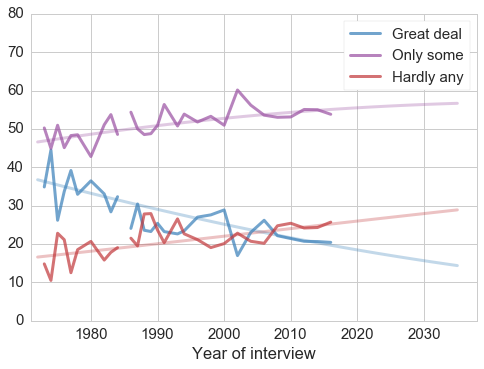

In [100]:
var = 'conclerg'
varnames = ['confident', 'someconf', 'noconf']
colors = [BLUE, PURPLE, RED]
train_year = 2016
years = np.arange(1972, 2036)
factors = ['ones', 'a', 'c']
index = varnames

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_conf(grouped_year, colors)

thinkplot.config(xlim=[1971, 2038], ylim=[0, 80])

## Bible

Which one of these statements comes closest to describing your feelings about the Bible? 

1. The Bible is the actual word of God and is to be taken literally, word for word

2. The Bible is the inspired word of God but not everything should be taken literally, word for word

3. The Bible is an ancient book of fables, legends, history and moral precepts recorded by man

In [101]:
sum(sample.bible.isnull())

29114

In [102]:
varnames = ['word', 'inspired', 'legends']

def create_bible_vars(df):
    """Creates columns for bible interpretation categories.
    
    df: DataFrame
    """
    df['word'] = (df.bible == 1)
    df['inspired'] = (df.bible == 2)
    df['legends'] = (df.bible == 3)

    df.loc[df.bible.isnull(), varnames] = np.nan
    
create_bible_vars(sample)

In [103]:
def plot_bible(grouped, colors):
    """Plot bible interpretation categories.
    
    grouped: GroupBy object
    """
    labels = ['Literal', 'Inspired', 'Legends']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

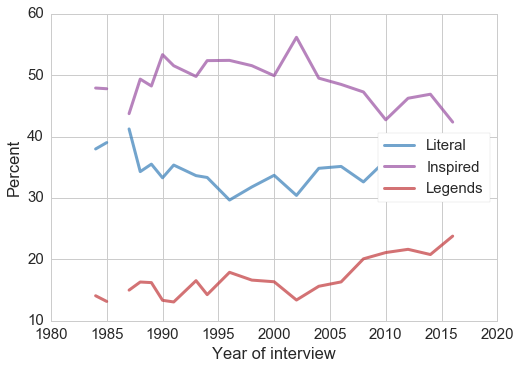

In [104]:
plot_bible(grouped_year, colors)
thinkplot.config(xlabel='Year of interview', ylabel='Percent', loc='center right')

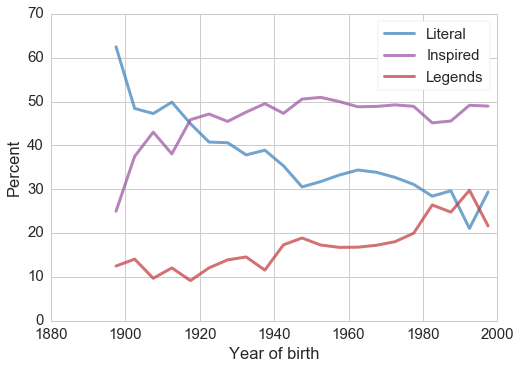

In [105]:
plot_bible(grouped_cohort, colors)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [106]:
make_model(sample, 'word').summary()

Optimization terminated successfully.
         Current function value: 0.636658
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   word   No. Observations:                32881
Model:                          Logit   Df Residuals:                    32875
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.005523
Time:                        20:29:23   Log-Likelihood:                -20934.
converged:                       True   LL-Null:                       -21050.
                                        LLR p-value:                 3.075e-48
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7239      0.023    -31.978      0.000      -0.768      -0.680
c              0.0080      0.004      2.223      0.026       0.001       0.015
c2             0.0005      0.000      3.841      0.000       0.000       0.001
a              0.0167      0.004      4.534      0.000       0.010       0.024
a2             0.0006      0.000      4.119      0.000       0.000       0.001
ac             0.0011      0.000      3.725      0.000       0.001       0.002
==============================================================================
"""

In [107]:
make_model(sample, 'inspired').summary()

Optimization terminated successfully.
         Current function value: 0.690517
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               inspired   No. Observations:                32881
Model:                          Logit   Df Residuals:                    32875
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.003170
Time:                        20:29:24   Log-Likelihood:                -22705.
converged:                       True   LL-Null:                       -22777.
                                        LLR p-value:                 2.056e-29
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1648      0.022     -7.661      0.000      -0.207      -0.123
c             -0.0315      0.003     -9.222      0.000      -0.038      -0.025
c2            -0.0010      0.000     -7.669      0.000      -0.001      -0.001
a             -0.0320      0.004     -9.092      0.000      -0.039      -0.025
a2            -0.0009      0.000     -6.321      0.000      -0.001      -0.001
ac            -0.0018      0.000     -6.818      0.000      -0.002      -0.001
==============================================================================
"""

In [108]:
make_model(sample, 'legends').summary()

Optimization terminated successfully.
         Current function value: 0.460638
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                legends   No. Observations:                32881
Model:                          Logit   Df Residuals:                    32875
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 May 2017   Pseudo R-squ.:                0.009958
Time:                        20:29:24   Log-Likelihood:                -15146.
converged:                       True   LL-Null:                       -15299.
                                        LLR p-value:                 9.908e-64
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3009      0.027    -48.646      0.000      -1.353      -1.249
c              0.0384      0.004      8.826      0.000       0.030       0.047
c2             0.0008      0.000      4.602      0.000       0.000       0.001
a              0.0271      0.005      5.994      0.000       0.018       0.036
a2             0.0006      0.000      2.922      0.003       0.000       0.001
ac             0.0014      0.000      3.995      0.000       0.001       0.002
==============================================================================
"""

Optimization terminated successfully.
         Current function value: 1.017204
         Iterations 5


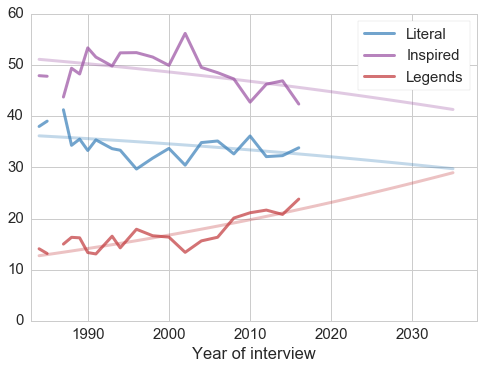

In [109]:
var = 'bible'
varnames = ['word', 'inspired', 'legends']
colors = [BLUE, PURPLE, RED]
train_year = 2016
years = np.arange(1984, 2036)
factors = ['ones', 'a', 'c']
index = varnames

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_bible(grouped_year, colors)

thinkplot.config(xlim=[1983, 2038], ylim=[0, 60])